# This notebook visualize the cell identification applied to an example radar reflectivity snapshot
# The parameters are read from the cell tracking config file

In [1]:
import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import colorcet as cc
from pyflextrkr.ft_utilities import load_config
from pyflextrkr.steiner_func import make_dilation_step_func
from pyflextrkr.steiner_func import mod_steiner_classification
from pyflextrkr.steiner_func import expand_conv_core
%matplotlib inline

In [2]:
# Input reflectivity file name
indir = '/pscratch/sd/f/feng045/SAAG/hist/auxhist/refl/2019/'
infile = f'{indir}refl_2019-01-23_21_15_00.nc'

# Cell tracking config file
config_file = '/global/homes/f/feng045/program/pyflex_config/config/config_saag_wrf4km_template.yml'

print(f'Input reflectivity file: {infile}')
print(f'Config file: {config_file}')

Input reflectivity file: /pscratch/sd/f/feng045/SAAG/hist/auxhist/refl/2019/refl_2019-01-23_21_15_00.nc
Config file: /global/homes/f/feng045/program/pyflex_config/config/config_saag_wrf4km_template.yml


In [3]:
# Load configuration file
config = load_config(config_file)
config

{'run_idfeature': True,
 'run_advection': False,
 'run_tracksingle': False,
 'run_gettracks': False,
 'run_trackstats': False,
 'run_mapfeature': False,
 'run_parallel': 0,
 'nprocesses': 24,
 'dask_tmp_dir': '/tmp',
 'timeout': 360,
 'startdate': '20190123.2000',
 'enddate': '20190124.0000',
 'time_format': 'yyyy-mo-dd_hh:mm:ss',
 'databasename': 'refl_rainrate_',
 'wrfout_path': '/pscratch/sd/f/feng045/SAAG/hist/auxhist/refl/2019/',
 'wrfout_basename': 'refl_',
 'clouddata_path': '/pscratch/sd/f/feng045/SAAG/hist/auxhist/refl/2019/',
 'root_path': '/pscratch/sd/f/feng045/SAAG/hist/cell_tracking/2019/',
 'tracking_path_name': 'tracking',
 'stats_path_name': 'stats',
 'pixel_path_name': 'celltracking',
 'terrain_file': '/global/cfs/cdirs/m1657/gsharing/SAAG/map_data/wrf_landmask.nc',
 'rangemask_varname': 'mask110',
 'feature_type': 'radar_cells',
 'advection_field_threshold': 10,
 'advection_med_filt_len': 9,
 'advection_max_movement_mps': 60,
 'advection_mask_method': 'greater',
 'ad

In [4]:
absConvThres = config['absConvThres']
minZdiff = config['minZdiff']
truncZconvThres = config['truncZconvThres']
mindBZuse = config['mindBZuse']
dBZforMaxConvRadius = config['dBZforMaxConvRadius']
conv_rad_increment = config['conv_rad_increment']
conv_rad_start = config['conv_rad_start']
bkg_refl_increment = config['bkg_refl_increment']
maxConvRadius = config['maxConvRadius']
radii_expand = config['radii_expand']
weakEchoThres = config['weakEchoThres']
bkgrndRadius = config['bkgrndRadius']
min_corearea = config['min_corearea']
echotop_gap = config['echotop_gap']
sfc_dz_min = config['sfc_dz_min']
sfc_dz_max = config['sfc_dz_max']
return_diag = config['return_diag']
dx = config['dx']
dy = config['dy']
z_dimname = config.get('z_dimname', 'z')
fillval = config['fillval']
input_source = config['input_source']
geolimits = config.get('geolimits', None)
convolve_method = config.get('convolve_method', 'ndimage')

# sfc_dz_min = config['sfc_dz_min']
# sfc_dz_max = config['sfc_dz_max']
radar_sensitivity = config['radar_sensitivity']
time_dimname = config.get('time', 'time')
x_dimname = config.get('x_dimname', 'x')
y_dimname = config.get('y_dimname', 'y')
z_dimname = config.get('z_dimname', 'z')
x_coordname = config.get('x_coordname')
y_coordname = config.get('y_coordname')
reflectivity_varname = config['reflectivity_varname']

types_steiner = {
    'NO_SURF_ECHO': 1,
    'WEAK_ECHO': 2,
    'STRATIFORM': 3,
    'CONVECTIVE': 4,
}

In [5]:
# Read input data
ds = xr.open_dataset(infile)
# grid_lon = ds[x_coordname].squeeze()
# grid_lat = ds[y_coordname].squeeze()
ds

<xarray.Dataset>
Dimensions:    (lat: 110, lon: 94, time: 1)
Coordinates:
  * time       (time) datetime64[ns] 2019-01-23T21:15:00
Dimensions without coordinates: lat, lon
Data variables:
    longitude  (lat, lon) float32 ...
    latitude   (lat, lon) float32 ...
    tb         (time, lat, lon) float32 ...
    rainrate   (time, lat, lon) float64 ...
    REFL_COM   (time, lat, lon) float32 ...
Attributes:
    Title:        WRF subset auxhist data
    Contact:      Zhe Feng: zhe.feng@pnnl.gov
    Institution:  Pacific Northwest National Laboratory
    created on:   Tue Feb 13 15:42:12 2024
    DX:           4000.0
    DY:           4000.0

In [6]:
# Get radar variables
dbz_comp = ds[reflectivity_varname].squeeze()
    
# Make a copy of the composite reflectivity (must do this or the dbz_comp will be altered)
refl = np.copy(dbz_comp.values)
# Replace all values less than min radar sensitivity, including NAN, to be equal to the sensitivity value
# The purpose is to include areas surrounding isolated cells below radar sensitivity
# in the background intensity calculation.
# This differs from Steiner.
refl[(refl < radar_sensitivity) | np.isnan(refl)] = radar_sensitivity
# Create a good value mask (everywhere is good for WRF)
mask_goodvalues = np.full(dbz_comp.shape, 1, dtype=int)

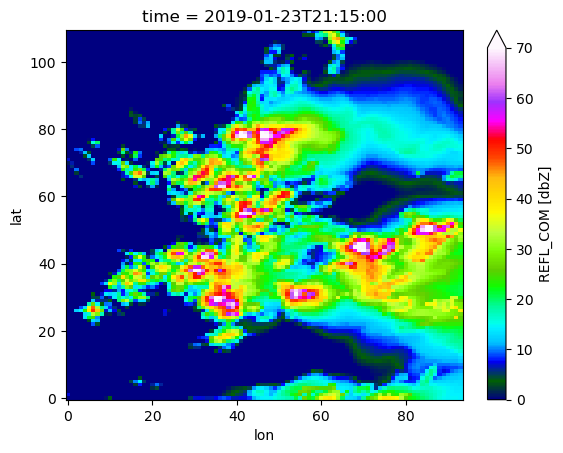

In [7]:
dbz_comp.plot(vmin=0, vmax=70, cmap='gist_ncar')

In [8]:
# Convert radii_expand from a list to a numpy array
radii_expand = np.array(radii_expand)

# Make step function for convective radius dilation
bkg_bin, conv_rad_bin = make_dilation_step_func(
    mindBZuse,
    dBZforMaxConvRadius,
    bkg_refl_increment,
    conv_rad_increment,
    conv_rad_start,
    maxConvRadius,
)

In [9]:
mindBZuse, dBZforMaxConvRadius, bkg_refl_increment, conv_rad_increment, conv_rad_start, maxConvRadius

(25, 60, 5, 0.5, 5.8, 9.0)

In [10]:
bkg_bin, conv_rad_bin

(array([  0.,  25.,  30.,  35.,  40.,  45.,  50.,  55.,  60., 100.]),
 array([5.8, 6.3, 6.8, 7.3, 7.8, 8.3, 8.8, 9. , 9. ]))

In [11]:
# Run Steiner classification
convsf_steiner, \
core_steiner, \
core_dilate, \
refl_bkg, \
peakedness, \
core_steiner_orig = mod_steiner_classification(
    types_steiner, refl, mask_goodvalues, dx, dy,
    bkg_rad=bkgrndRadius * 1000,
    minZdiff=minZdiff,
    absConvThres=absConvThres,
    truncZconvThres=truncZconvThres,
    weakEchoThres=weakEchoThres,
    bkg_bin=bkg_bin,
    conv_rad_bin=conv_rad_bin,
    min_corearea=min_corearea,
    remove_smallcores=True,
    return_diag=return_diag,
    convolve_method=convolve_method,
)

In [12]:
# Expand convective cell masks outward to a set of radii to
# increase the convective cell footprint for better tracking convective cells
core_expand, core_sorted = expand_conv_core(
    core_dilate, radii_expand, dx, dy, min_corenpix=0)

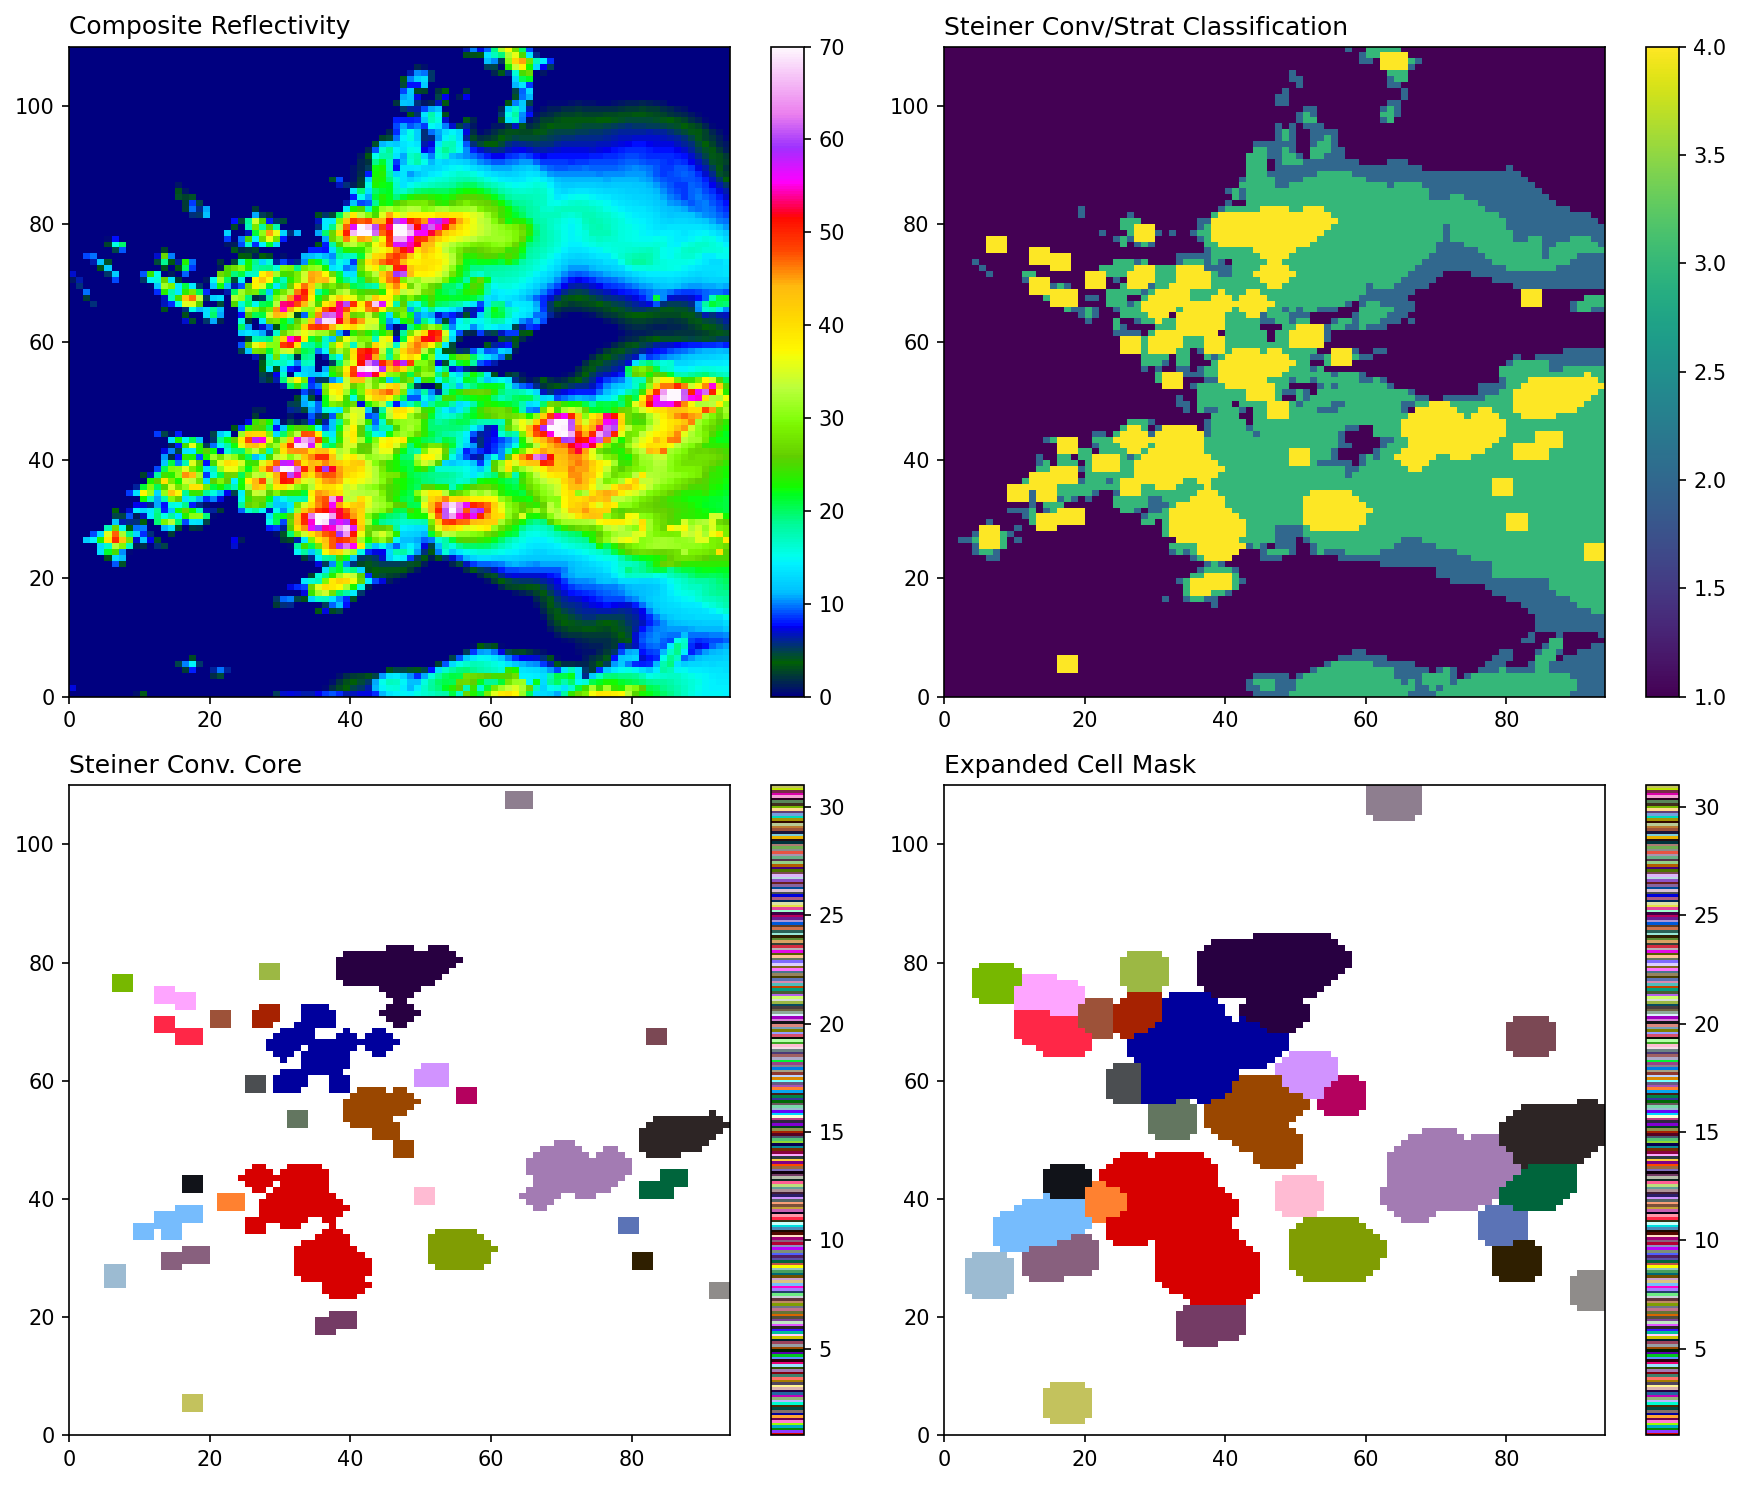

In [13]:
fig, axes = plt.subplots(2, 2, figsize=[12,10], dpi=150)
ax0 = axes[0,0]
cm0 = ax0.pcolormesh(dbz_comp, vmin=0, vmax=70, cmap='gist_ncar')
ax0.set_title('Composite Reflectivity', loc='left')
plt.colorbar(cm0, ax=ax0)

ax1 = axes[0,1]
cm1 = ax1.pcolormesh(convsf_steiner)
ax1.set_title('Steiner Conv/Strat Classification', loc='left')
plt.colorbar(cm1, ax=ax1)

ax2 = axes[1,0]
core_mask = core_expand * core_dilate
Zm = np.ma.masked_where(core_mask == 0, core_expand)
cm2 = ax2.pcolormesh(Zm, cmap=cc.cm['glasbey_bw'])
ax2.set_title('Steiner Conv. Core', loc='left')
plt.colorbar(cm2, ax=ax2)

ax3 = axes[1,1]
Zm = np.ma.masked_where(core_expand == 0, core_expand)
cm3 = ax3.pcolormesh(Zm, cmap=cc.cm['glasbey_bw'])
ax3.set_title('Expanded Cell Mask', loc='left')
plt.colorbar(cm3, ax=ax3)

fig.tight_layout()

In [14]:
# Create variables needed for tracking
feature_mask = core_expand
# Count number of pixels for each feature
unique_num, npix_feature = np.unique(feature_mask, return_counts=True)
# Remove background (unique_num = 0)
npix_feature = npix_feature[(unique_num > 0)]
# Get number of features
nfeatures = np.nanmax(feature_mask)

In [15]:
npix_feature

array([396, 276, 254, 229, 162, 137, 131,  97,  70,  67,  68,  55,  63,
        56,  45,  52,  32,  46,  45,  37,  45,  43,  42,  43,  39,  33,
        45,  33,  31,  43,  45])